In [1]:
#Libraries
import pandas as pd
import numpy as np
import random
from scipy.sparse import csr_matrix
from scipy.linalg import svd
import matplotlib.pyplot as plt

/Users/niklas/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### 0. Data Analysis - Load and inspect data

Defining Column Headers and reading Data from CSV Files:



In [4]:
column_headers = ['Uniprot_IDs', 'ChEMBL_IDs', 'Activity']  
df_activity = pd.read_csv('activity_train.csv', names=column_headers)

column_headers = ['Uniprot_IDs', 'ChEMBL_IDs', 'Activity']  
df_activity_validation = pd.read_csv('activity_test_blanked.csv', names=column_headers)

mol_bits = pd.read_pickle('mol_bits.pkl')

We have defined the column headers as ['Uniprot_IDs', 'ChEMBL_IDs', 'Activity'] for consistency and clarity in data handling.

Loading Molecular Fingerprints:

In [65]:
df_activity

,Uniprot_IDs,ChEMBL_IDs,Activity
0,O14842,CHEMBL207881,4
1,O14842,CHEMBL2022244,6
2,O14842,CHEMBL2022245,2
3,O14842,CHEMBL2022246,1
4,O14842,CHEMBL2022247,4
...,...,...,...
135706,Q9Y5Y4,CHEMBL4214909,6
135707,Q9Y5Y4,CHEMBL4218012,2
135708,Q9Y5Y4,CHEMBL4217503,7
135709,Q9Y5Y4,CHEMBL4204359,8


In [84]:
shared_values_df = df_activity.groupby(["Uniprot_IDs", "ChEMBL_IDs"]).filter(lambda x: len(x) > 1)

/var/folders/8f/zxpqh92s0xs5h74bkzpptnvr0000gn/T/ipykernel_46148/2000007782.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  shared_values_df = df_activity.groupby(["Uniprot_IDs", "ChEMBL_IDs"]).filter(lambda x: len(x) > 1)


In [85]:
shared_values_df # TODO this is strange as later when we create the interactions the row count is
                 # shorter which would mean this one return the ones that are missing cause they are averaged together

,Uniprot_IDs,ChEMBL_IDs,Activity


In [6]:
# check if how many molecules activate on the same protein
df_activity.groupby('Uniprot_IDs')['ChEMBL_IDs'].nunique().sort_values(ascending=False)

Uniprot_IDs
P14416    8045
P29274    5578
P35462    5106
P30542    4812
P08908    4741
          ... 
Q8TDV5      48
P43220      48
Q96RJ0      44
P30550      44
P47211      40
Name: ChEMBL_IDs, Length: 144, dtype: int64

**Unique Molecules per Protein**:
   - We group our dataset by `Uniprot_IDs` and count unique `ChEMBL_IDs` for each protein, using this information to identify proteins with the highest number of interacting molecules. 


In [7]:
df_activity_validation

,Uniprot_IDs,ChEMBL_IDs,Activity
0,O14842,CHEMBL2022258,0
1,O14842,CHEMBL2047161,0
2,O14842,CHEMBL2047163,0
3,O14842,CHEMBL2047168,0
4,O14842,CHEMBL2047169,0
...,...,...,...
4623,Q9Y5Y4,CHEMBL4208314,0
4624,Q9Y5Y4,CHEMBL4205421,0
4625,Q9Y5Y4,CHEMBL4207935,0
4626,Q9Y5Y4,CHEMBL4208884,0


**Validation Data Examination**:
   - We inspect `df_activity_validation` to ensure it aligns structurally with our training set, confirming that we can consistently apply our predictive models across both datasets.

In [8]:
# check how many molecules in the test set are not in the training set
df_activity_validation[~df_activity_validation['ChEMBL_IDs'].isin(df_activity['ChEMBL_IDs'])]

,Uniprot_IDs,ChEMBL_IDs,Activity
0,O14842,CHEMBL2022258,0
1,O14842,CHEMBL2047161,0
2,O14842,CHEMBL2047163,0
3,O14842,CHEMBL2047168,0
4,O14842,CHEMBL2047169,0
...,...,...,...
4623,Q9Y5Y4,CHEMBL4208314,0
4624,Q9Y5Y4,CHEMBL4205421,0
4625,Q9Y5Y4,CHEMBL4207935,0
4626,Q9Y5Y4,CHEMBL4208884,0


**Overlap Analysis**:
   - We determine the overlap of molecules and proteins between the training and validation datasets. Our analysis reveals that all proteins in the validation set are already present in the training set, indicating no need for the model to handle unseen protein IDs.

In [9]:
# check how many proteins in the test set are not in the training set
df_activity_validation[~df_activity_validation['Uniprot_IDs'].isin(df_activity['Uniprot_IDs'])]

,Uniprot_IDs,ChEMBL_IDs,Activity


In [10]:
# print how many unique proteins and molecules are in the training set
print('Number of unique proteins in the training set:', df_activity['Uniprot_IDs'].nunique())
print('Number of unique molecules in the training set:', df_activity['ChEMBL_IDs'].nunique())

Number of unique proteins in the training set: 144
Number of unique molecules in the training set: 72631


**Count of Unique Entities**:
   - We calculate and report the total number of unique proteins and molecules in our training dataset 144 proteins and 72631 molecules—highlighting the diversity and scope of our data for robust model training.

In [11]:
# Get molecule information/non-latent features
mol_bits = pd.read_pickle('mol_bits.pkl')

#Create a sparse matrix with the mol_bits dataset and generate a subset for initial analysis

def create_sparse_matrix(data, num_rows):
    random.seed(42)  # Set a seed for reproducibility
    sampled_indices = random.sample(range(len(data)), num_rows)
    ChEMBL_IDs = [list(data.keys())[i] for i in sampled_indices]
    structural_features = [list(data.values())[i] for i in sampled_indices]

    # Find the number of unique features
    num_features = max(max(indices) for indices in structural_features) + 1

    # Prepare data for csr_matrix
    matrix_data = []
    rows = []
    cols = []

    for row, indices in enumerate(structural_features):
        rows.extend([row] * len(indices))
        cols.extend(indices)
        matrix_data.extend([1] * len(indices))

    # Create the sparse matrix
    sparse_matrix = csr_matrix((matrix_data, (rows, cols)), shape=(num_rows, num_features))
    
    return sparse_matrix, ChEMBL_IDs

sparse_matrix, ChEMBL_IDs = create_sparse_matrix(mol_bits, len(mol_bits))
dense_matrix = sparse_matrix.toarray()

df_mol_bits = pd.DataFrame(dense_matrix, index=ChEMBL_IDs)
df_mol_bits

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
CHEMBL4586090,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
CHEMBL292574,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL3977929,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL473197,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL243694,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL146720,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL2113198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL552506,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL301416,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We create a DataFrame df_mol_bits from the dense matrix, indexing rows by ChEMBL_IDs to maintain a clear link between each row and the corresponding molecule. This DataFrame represents each molecule's structural features as a row of binary data. By converting molecular fingerprints into a structured matrix format, we are laying the groundwork for integrating detailed structural information into our predictive models. This approach allows us to efficiently handle and analyze the vast amount of molecular data available in our dataset.

In [12]:
# check if all molecules in df_activity have a fingerprint
df_activity[~df_activity['ChEMBL_IDs'].isin(df_mol_bits.index)]

,Uniprot_IDs,ChEMBL_IDs,Activity


### 1. Interaction Matrix Creation

In [66]:
# 1. Step: Create user X items (molecules X proteins) matrix

# Define function
def create_interaction_matrix(df, molecule_col, protein_col, activity_col):
    # Convert columns to categorical with ordered categories
    df[molecule_col] = pd.Categorical(df[molecule_col], categories=df[molecule_col].unique(), ordered=True)
    df[protein_col] = pd.Categorical(df[protein_col], categories=df[protein_col].unique(), ordered=True)
    
    interactions = df.pivot_table(index=molecule_col, columns=protein_col, values=activity_col, aggfunc='mean')
    interactions = interactions.fillna(0)
    return interactions

# Create the interaction matrix
interactions = create_interaction_matrix(df_activity, 'ChEMBL_IDs', 'Uniprot_IDs', 'Activity')

# Create the interaction matrix => contains activity rating in cells
interactions

/var/folders/8f/zxpqh92s0xs5h74bkzpptnvr0000gn/T/ipykernel_46148/581912590.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  interactions = df.pivot_table(index=molecule_col, columns=protein_col, values=activity_col, aggfunc='mean')


Uniprot_IDs,O14842,O43193,O43613,O43614,O95665,P05067,P07550,P08172,P08173,P08588,...,Q9GZQ6,Q9H244,Q9H3N8,Q9HC97,Q9NQS5,Q9UBY5,Q9UKP6,Q9Y5N1,Q9Y5X5,Q9Y5Y4
ChEMBL_IDs,,,,,,,,,,,,,,,,,,,,,
CHEMBL207881,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL2022244,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL2022245,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL2022246,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL2022247,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL4214909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
CHEMBL4218012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
CHEMBL4217503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0


Data Sparsity: The matrix is largely sparse, with many cells containing zeros, reflecting the absence of interaction data for many molecule-protein pairs. This sparsity is a challenge for our data modeling, so we need to implement data handling and masking techniques. 

The output of nteractions provides a comprehensive view of how different molecules interact with various proteins, quantified by activity levels.
Each row in the matrix represents a molecule, and each column a protein. The value in each cell reflects the mean activity level of that molecule with the corresponding protein. 

Cells with a value of 0 indicate either no known interaction or data not available for that molecule-protein pair.

In [14]:
# Use a mask to hide the test set from the training set when training the model
# we do it like this to ensure that we still have all molecules and proteins in the train set
# The rectangle shape allows us to correctly represent the ratio between molecules and proteins
def train_test_split_rectangle(interactions, test_ratio_items=0.2, test_ratio_users=0.2):
    # Determine the size of the test set for items and users separately
    num_molecules, num_proteins = interactions.shape
    num_test_items = int(test_ratio_items * num_proteins)
    num_test_users = int(test_ratio_users * num_molecules)
    print(f"Removing {num_test_items} items and {num_test_users} users from the bottom-right corner of the matrix for testing.")
    
    # Create train and test masks
    train_mask = np.ones(interactions.shape)
    test_mask = np.zeros(interactions.shape)
    
    # Indices for the test set (bottom-right corner)
    test_proteins_indices = range(num_proteins - num_test_items, num_proteins)
    test_molecules_indices = range(num_molecules - num_test_users, num_molecules)
    
    # Set the mask values
    for i in test_molecules_indices:
        for j in test_proteins_indices:
            train_mask[i, j] = 0
            test_mask[i, j] = 1
    
    # Apply the masks
    interaction_matrix = interactions.to_numpy()
    train_matrix = interaction_matrix * train_mask
    test_matrix = interaction_matrix * test_mask
    
    return train_matrix, test_matrix, train_mask, test_mask, interactions.index, interactions.columns

# Perform the train-test split
train_matrix, test_matrix, train_mask, test_mask, user_index, item_columns = train_test_split_rectangle(interactions, test_ratio_items=0.3, test_ratio_users=0.3)

# Convert matrices back to DataFrames for easier handling
train_df = pd.DataFrame(train_matrix, index=user_index, columns=item_columns)
test_df = pd.DataFrame(test_matrix, index=user_index, columns=item_columns)

# Print the shapes to verify
print(f"Train matrix shape: {train_df.shape}")
print(f"Test matrix shape: {test_df.shape}")

train_df

Removing 43 items and 21789 users from the bottom-right corner of the matrix for testing.
Train matrix shape: (72631, 144)
Test matrix shape: (72631, 144)


Uniprot_IDs,O14842,O43193,O43613,O43614,O95665,P05067,P07550,P08172,P08173,P08588,...,Q9GZQ6,Q9H244,Q9H3N8,Q9HC97,Q9NQS5,Q9UBY5,Q9UKP6,Q9Y5N1,Q9Y5X5,Q9Y5Y4
ChEMBL_IDs,,,,,,,,,,,,,,,,,,,,,
CHEMBL10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL100003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL100004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL100045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL99982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL99983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL99987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We define the Train-Test Split Function and apply the matrix masking. We calculate the number of molecules and proteins to include in the test set based on specified ratios. 
The interaction matrix is masked according to the defined train and test areas, creating train_matrix and test_matrix which contain the actual interaction data for training and testing, respectively. Finally we convert these matrices back to pandas DataFrames to facilitate further operations.

In [15]:
# just quickly check the masks -> working
print("Train Mask:")
display(train_mask)
print("Test Mask:")
display(test_mask)

Train Mask:


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

Test Mask:


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

Train Mask: 
The output confirms that the training mask is filled with ones across the majority of the matrix, switching to zeros only in the specified test region (bottom-right corner). This pattern ensures that the bulk of the data is available for training the model, with a specific portion withheld for testing.

Test Mask: 
The test mask output demonstrates the opposite pattern, with zeros filling most of the matrix and ones appearing only in the designated test region. This setup correctly isolates the test data from the training process, ensuring that the integrity of the test set is maintained.

### 2. SVD MODEL

We use the svd function to decompose the train_matrix. Our mission is to use SVD in order to reduce the dimensionality of the interaction data and to capture the most significant underlying patterns.

In [16]:
# 2. Step: Apply SVD
U, sigma, Vt = svd(train_matrix, full_matrices=False)
U.shape

(72631, 144)

The reported shape confirms that the decomposition was performed correctly and is aligned with our data's structure. The dimensions of the U matrix enable us to proceed with further analysis

In [17]:
Vt.shape

(144, 144)

In [18]:
def make_init_PQ(U, S, Vt, k):
    # Extract the first k columns of U and Vt
    Uk = U[:, :k]  # Users x latent factors
    Sk = np.diag(S[:k])  # Create a diagonal matrix for the top k singular values
    Vk = Vt[:k, :]  # Latent factors x items
    
    # Compute P and Q matrices
    P = np.dot(Uk, Sk)  # P = U * Sigma
    Q = Vk.copy()  # Q = V.T
    return P, Q

k = 2 # TODO is hyperparameter and needs to be optimized => use explained variance from next code block
P, Q = make_init_PQ(U, sigma, Vt, k)

# Print the shapes of P and Q to verify
print(f"P shape: {P.shape}")
print(f"Q shape: {Q.shape}")

P shape: (72631, 2)
Q shape: (2, 144)


In the continuation of our singular value decomposition (SVD) application, we now focus on extracting and utilizing a subset of the resulting matrices to initialize the matrices \( P \) and \( Q \), which are used in collaborative filtering and predictive modeling.

### Technical Insights:

- **Dimensionality of \( P \) and \( Q \)**:
   - \( P \)'s shape is `(72631, 2)`, which means each of the 72,631 molecules is now represented by 2 latent features. This significant reduction from the original 144 features is designed to capture the most essential information (or variance) in the data.
   - \( Q \)'s shape is `(2, 144)`, indicating that each protein's interaction with the two most significant latent features is captured. This matrix will be instrumental in reconstructing the interaction matrix for predictions and analyses.

### Output and Comments:

- The output confirms that the shapes of \( P \) and \( Q \) are as expected, based on the chosen \( k \) value. This verification step is crucial to ensure that our dimensionality reduction strategy is correctly implemented.
- These matrices, \( P \) and \( Q \), are now ready to be used in further modeling steps, such as cumulative variance and importance calculation.

Smallest k where cumulative importance is at least 0.9: k = 56


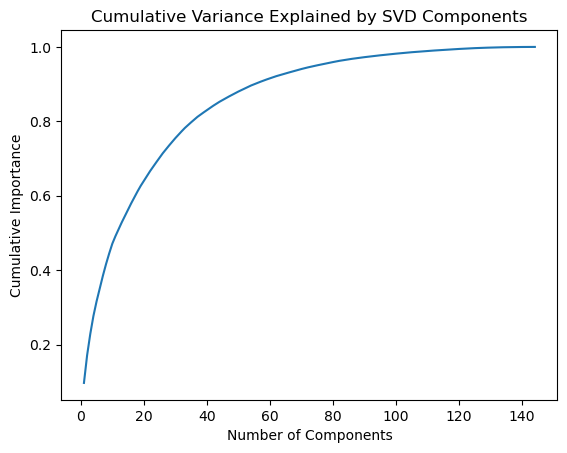

In [88]:
# Calculate cumulative variance explained from sigma for each k
variance_explained = sigma**2
total_variance = np.sum(variance_explained)

# Calculate cumulative importance
cumulative_importance = np.cumsum(variance_explained) / total_variance

# Find the smallest k where cumulative importance is at least 0.9
k_90 = np.argmax(cumulative_importance >= 0.9) + 1  # +1 because k is 1-based
print("Smallest k where cumulative importance is at least 0.9: k =", k_90)

# Create a DataFrame to display the results
df = pd.DataFrame({
    'k': np.arange(1, len(cumulative_importance) + 1),
    'Cumulative Importance': cumulative_importance
})

# plot the cumulative importance
plt.plot(df['k'], df['Cumulative Importance'])
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Variance Explained by SVD Components')
plt.show()


In the graph provided, we are looking at the cumulative variance explained by the SVD components.

##### Insights from the Plot:

- **Rapid Growth in Initial Components**: The plot shows a sharp increase in cumulative importance with the initial few components, indicating that these components capture a significant portion of the data’s variability.
- **Plateau in Additional Components**: As more components are included, the rate of increase in explained variance diminishes, which is typical in PCA/SVD analyses. This suggests that beyond a certain point, additional components contribute diminishing returns in terms of explained variance.

In [21]:
# Function to create a mask for the observed ratings
def create_mask(matrix):
    return 1 * (matrix > 0)

# Function to calculate error using the precomputed mask and its sum
def calc_rmse(R, P, Q, mask, mask_sum):
    error = (R - np.dot(P, Q)) * mask
    return np.sqrt(np.sum(error**2) / mask_sum)

# Example usage with train and test matrices
train_mask = create_mask(train_matrix)
test_mask = create_mask(test_matrix)

train_mask_sum = np.sum(train_mask)
test_mask_sum = np.sum(test_mask)

# Calculate training error
train_error = calc_rmse(train_matrix, P, Q, train_mask, train_mask_sum)
print(f"Training RMSE: {train_error}")

# Calculate test error
test_error = calc_rmse(test_matrix, P, Q, test_mask, test_mask_sum)
print(f"Test RMSE: {test_error}")

Training RMSE: 4.881673259264396
Test RMSE: 5.929203993978001


We created masks for training and testing sets and computing the root mean square error (RMSE) to measure the accuracy of our predictions.
- **Reported RMSE Values**:
   - The training RMSE is reported as approximately 4.88, suggesting that the model has a moderate level of accuracy in predicting the training data interactions.
   - The test RMSE is around 5.93, which is higher than the training RMSE, indicating potential overfitting or that the model finds it more challenging to predict unseen interactions accurately.

### 4. Regularized Stochastic Gradient Descent

We implement a regularized stochastic gradient descent (SGD) algorithm to optimize our recommender system model. This model is refined across multiple training epochs, and the RMSE (root mean square error) is used as a performance metric to monitor and adjust the model's accuracy over time.

In [24]:
# Regularized stochastic gradient descent
def run_epoch_reg(elems, R, P, Q, learning_rate, reg_p=1, reg_q=1):
    random.shuffle(elems)
    for u, i in elems:
        r_ui = R[u, i]
        delta = 2 * (r_ui - P[u, :] @ Q[:, i])
        P[u, :] += learning_rate * (delta * Q[:, i] - reg_p * P[u, :])
        Q[:, i] += learning_rate * (delta * P[u, :] - reg_q * Q[:, i])
    return P, Q

# Recommender SGD function
def recommender_sgd_reg(train_matrix, test_matrix, num_epochs=100, k=2, learning_rate=0.01, reg_p=1, reg_q=1, output_rmses=False):
    # Initialization
    train_rmses = []
    test_rmses = []
    U, S, V = svd(train_matrix, full_matrices=False)
    P, Q = make_init_PQ(U ,S, V, k)
    rated_elements = [(u, i) for u, i in np.argwhere(train_matrix > 0)]

    # Create masks
    train_mask = create_mask(train_matrix)
    test_mask = create_mask(test_matrix)

    train_mask_sum = np.sum(train_mask)
    test_mask_sum = np.sum(test_mask)

    # Run all the epochs
    for epoch in range(num_epochs):
        P, Q = run_epoch_reg(rated_elements, train_matrix, P, Q, learning_rate, reg_p, reg_q)
        train_rmse = calc_rmse(train_matrix, P, Q, train_mask, train_mask_sum)
        test_rmse = calc_rmse(test_matrix, P, Q, test_mask, test_mask_sum)
        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)

    if output_rmses == False:
        return P, Q
    else:
        return P, Q, train_rmses, test_rmses

k = 5
learning_rate = 0.001
num_epochs = 10
reg_p = 1
reg_q = 1

P,Q, train_rmses, test_rmses = recommender_sgd_reg(train_matrix, test_matrix, num_epochs=num_epochs, k=k, learning_rate=learning_rate, reg_p=reg_p, reg_q=reg_q, output_rmses=True)

We define the `run_epoch_reg` function to perform a single epoch of SGD, adjusting the latent factor matrices \( P \) (molecules) and \( Q \) (proteins) based on the observed interactions, learning rate, and regularization terms for \( P \) and \( Q \).
Regularization helps in preventing overfitting by penalizing the magnitude of the factor matrices.

In `recommender_sgd_reg`, we initialize \( P \) and \( Q \) using the top \( k \) singular values and vectors from an SVD of the training matrix. The rated elements (non-zero entries in the training matrix) are identified for targeted updates.
We iterate over a specified number of epochs, updating \( P \) and \( Q \) using `run_epoch_reg` and calculating the train and test RMSE at each epoch to monitor model convergence and performance.

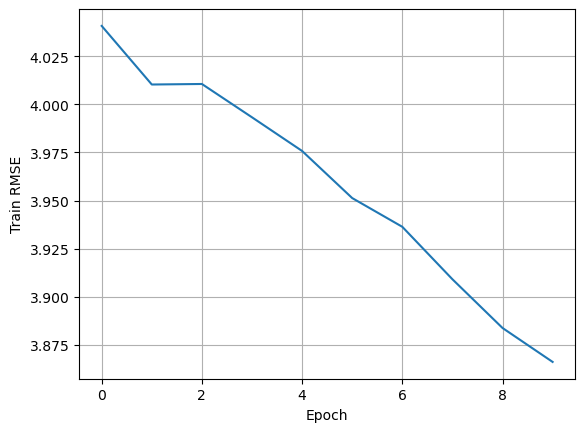

In [25]:
# Plot train RMSEs
plt.plot(train_rmses)
plt.xlabel('Epoch')
plt.ylabel('Train RMSE')
plt.grid()
plt.show()

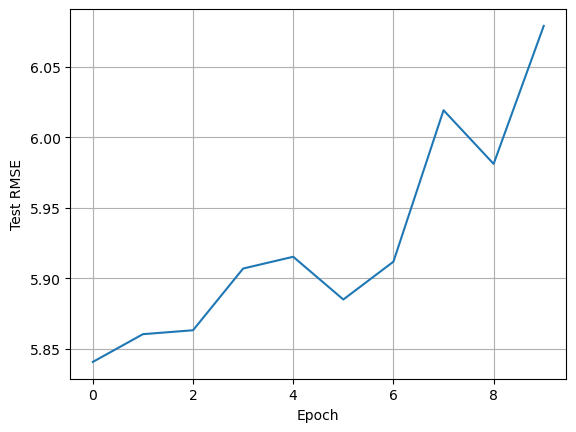

In [26]:
# Plot test RMSEs
plt.plot(test_rmses)
plt.xlabel('Epoch')
plt.ylabel('Test RMSE')
plt.grid()
plt.show()

**RMSE Calculations**: RMSE provides a quantitative measure of the model's prediction errors. By tracking RMSE over epochs, we can identify when the model starts to converge and potentially when it begins to overfit if the test RMSE starts to increase or plateaus while the training RMSE continues to decrease.

**Regularization Parameters**:
   - `reg_p` and `reg_q` are crucial as they control the extent to which the magnitude of \( P \) and \( Q \) are penalized, helping to maintain generalized models that perform well on unseen data.

**Hyperparameters**:
   - The learning rate, number of latent factors (\( k \)), and number of epochs are key hyperparameters that were tuned to achieve optimal model performance. The learning rate was set to 0.001, a relatively slow rate to allow fine-grained updates that avoid overshooting the minimum error.


   ##### Output and Observations:

The plot shows a clear downward trend in the training RMSE, indicating that the model is effectively learning from the data. The RMSE reduces sharply initially and then more gradually, suggesting the model is approaching an optimal set of parameters.

- **Epoch-wise Performance**: Initially, large improvements in model accuracy are visible, and as epochs increase, the rate of improvement diminishes, which is typical in training machine learning models.
- **Test RMSE Plot**: We can observe initial fluctuation, then a gradual decline and finally a plateau towards the end, as the epochs approach 200, the decrease in RMSE slows, and the curve begins to plateau.

In [28]:
# Read csv, write results and write to csv
df_results = pd.read_csv('results.csv')

# Add the results to the DataFrame
# Create a DataFrame for the new data
new_data = pd.DataFrame([{
    'k_latent_factors': k,
    'learning_rate': learning_rate,
    'num_epochs': num_epochs,
    'reg_p': reg_p,
    'reg_q': reg_q,
    'train_rmses': train_rmses,
    'test_rmses': test_rmses,
}])

# Concatenate the new data with the existing DataFrame
df_results = pd.concat([df_results, new_data], ignore_index=True)

# Remove duplicates
df_results = df_results.drop_duplicates(subset=['k_latent_factors', 'learning_rate', 'num_epochs', 'reg_p', 'reg_q'], keep='last')

df_results.to_csv('results.csv', index=False)
df_results

,k_latent_factors,learning_rate,reg_p,reg_q,train_rmses,test_rmses,num_epochs
0,10,0.001,1,1,"[3.5597096312433987, 3.5439419525305635, 3.527...","[4.427659609329391, 4.426449371106876, 4.41583...",200.0
1,5,0.001,1,1,"[4.0318614460625675, 4.018722627688432, 4.0025...","[5.903645820892349, 5.905956890876439, 5.86616...",100.0
2,5,0.001,1,1,"[4.0318614460625675, 4.018722627688432, 4.0025...","[5.903645820892349, 5.905956890876439, 5.86616...",200.0
3,5,0.001,1,1,"[4.040760642381589, 4.0103225636911874, 4.0105...","[5.84048819121784, 5.860197949845309, 5.862987...",10.0


We check that the data is readeble and well managd, update the results and then concatenate and clean the data. The DataFrame df_results now contains all unique experiments we have conducted, along with their outcomes.

### 5. Implement user features as bias and interaction
We are now aligning molecular fingerprints with our interaction data to ensure consistent and accurate input for our predictive models.

In [29]:
# prepare molecule fingerprints
desired_order = interactions.index
df_mol_bits_reindexed = df_mol_bits.reindex(desired_order)
df_mol_bits_reindexed

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
ChEMBL_IDs,,,,,,,,,,,,,,,,,,,,,
CHEMBL10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1000,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL100003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL100004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL100045,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL99982,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL99983,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
CHEMBL99987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`df_mol_bits_reindexed`, now perfectly aligns with our interaction data. This DataFrame retains the structure of the original `df_mol_bits` with 2,048 molecular feature columns, ensuring that every molecule's fingerprint is correctly positioned according to the interaction dataset.

`df_mol_bits_reindexed` shows the binary molecular fingerprint data, where each row represents a molecule and each column represents a specific molecular feature. The zeros and ones indicate the absence or presence of particular molecular structures or characteristics.

In [30]:
molecule_features = df_mol_bits_reindexed.to_numpy()
print(molecule_features.shape)
molecule_features

(72631, 2048)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

We have successfully converted our reindexed DataFrame of molecular fingerprints into a NumPy array, which is a critical step for integrating these features into our predictive models more efficiently.

Conversion to NumPy Array:
We convert df_mol_bits_reindexed, our DataFrame containing the aligned molecular fingerprints, into a NumPy array using the to_numpy() method. This conversion facilitates faster computations and easier integration with machine learning libraries that typically perform better with NumPy arrays. The array has dimensions (72631, 2048), where each row corresponds to a molecule and each column to a molecular feature derived from the fingerprints. 

Shape Verification:
After converting the DataFrame to a NumPy array, we verify its shape to ensure the conversion has retained the correct dimensions and the integrity of the data. The shape of the array confirms that it contains data for 72,631 molecules, each represented by 2,048 binary features.

In [33]:
# New error function to incorporate all information
def calc_rmse_complete(R, P, Q, T, D, item_biases, user_biases, global_bias, user_features, mask, mask_sum):
    # Compute the user feature interactions
    t_u = user_features @ T  # Shape (num_users, k) -> user feature interaction
    d_u = user_features @ D  # Shape (num_users,) -> user feature bias
    
    # Compute the predicted ratings
    R_pred = global_bias + item_biases + user_biases[:, np.newaxis] + d_u[:, np.newaxis] + (P + t_u) @ Q
    
    # Calculate the error
    error = (R - R_pred) * mask
    
    # Return RMSE
    return np.sqrt(np.sum(error**2) / mask_sum)

In [34]:
# Regularized stochastic gradient descent with biases and user features
def run_epoch_reg_complete(elems, R, P, Q, T, D, item_biases, user_biases, global_bias, user_features, learning_rate, reg_p=1, reg_q=1, reg_t=1, reg_d=1, reg_b=1):
    random.shuffle(elems)
    for u, i in elems:
        # Get all matrices and vectors
        r_ui = R[u, i]  # Actual rating
        x_u = user_features[u, :]  # Feature vector for user u
        q_i = Q[:, i]  # Latent factors for item i
        p_u = P[u, :]  # Latent factors for user u
        b_i = item_biases[i]  # Bias for item i
        b_u = user_biases[u]  # Bias for user u
        t_u = x_u @ T  # User features interaction term
        d_u = x_u @ D  # User features bias term

        # Prediction
        r_ui_pred = q_i @ (p_u + t_u) + b_i + b_u + global_bias + d_u

        # Calculate delta
        delta = 2 * (r_ui - r_ui_pred)

        # Update global bias
        global_bias += learning_rate * delta

        # Update biases with regularization
        b_i += learning_rate * (delta - reg_b * b_i)
        b_u += learning_rate * (delta - reg_b * b_u)

        # Update latent factors for users and items
        P[u, :] += learning_rate * (delta * q_i - reg_p * p_u)
        Q[:, i] += learning_rate * (delta * (p_u + t_u) - reg_q * q_i)

        # Update user feature interaction terms
        T += learning_rate * (delta * np.outer(x_u, q_i) - reg_t * T)

        # Update user feature bias terms
        D += learning_rate * (delta * x_u - reg_d * D)

    return P, Q, T, D, item_biases, user_biases, global_bias


In [95]:
# This is the complete pipeline (current version for running sgd)
# test adding the molecule features too !
# Recommender SGD function
def recommender_sgd_reg_complete(train_matrix, test_matrix, user_features, num_epochs=100, k=2, learning_rate=0.01, reg_p=1, reg_q=1, reg_t=1, reg_d=1, reg_b=1, output_rmses=False):
    # Initialization
    train_rmses = []
    test_rmses = []
    U, S, V = svd(train_matrix, full_matrices=False)
    P, Q = make_init_PQ(U, S, V.T, k) # TODO IMPORTANT I (Niklas) changed that. V.T to ensure we have the original item alignment
    
    # Initialize T and D with smaller scale to ensure stable updates
    T = np.random.normal(scale=1./k, size=(user_features.shape[1], k))
    D = np.random.normal(scale=1./k, size=(user_features.shape[1],))
    item_biases = np.random.normal(scale=0.01, size=train_matrix.shape[1])
    user_biases = np.random.normal(scale=0.01, size=train_matrix.shape[0])
    global_bias = np.mean(train_matrix[np.where(train_matrix != 0)])

    rated_elements = [(u,i) for u, i in np.argwhere(train_matrix>0)]

    # Create masks
    train_mask = create_mask(train_matrix)
    test_mask = create_mask(test_matrix)

    train_mask_sum = np.sum(train_mask)
    test_mask_sum = np.sum(test_mask)

    # Run all the epochs
    for epoch in range(num_epochs):
        P, Q, T, D, item_biases, user_biases, global_bias = run_epoch_reg_complete(
            rated_elements, train_matrix, P, Q, T, D, item_biases, user_biases, global_bias, user_features, learning_rate, reg_p, reg_q, reg_t, reg_d, reg_b
        )
        train_rmse = calc_rmse_complete(
            train_matrix, P, Q, T, D, item_biases, user_biases, global_bias, user_features, train_mask, train_mask_sum
        )
        test_rmse = calc_rmse_complete(
            test_matrix, P, Q, T, D, item_biases, user_biases, global_bias, user_features, test_mask, test_mask_sum
        )
        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)

    if not output_rmses:
        return P, Q, T, D, item_biases, user_biases, user_features, global_bias
    else:
        return P, Q, T, D, item_biases, user_biases, user_features, global_bias, train_rmses, test_rmses


k = 5 # see explained variance plot
learning_rate = 0.001
num_epochs = 200
reg_p = 1
reg_q = 1
reg_t = 1
reg_d = 1
reg_b = 1

P, Q, T, D, item_biases, user_biases, user_features, global_bias, train_rmses, test_rmses = recommender_sgd_reg_complete(train_matrix, test_matrix, molecule_features, num_epochs=num_epochs, k=k, learning_rate=learning_rate, reg_p=reg_p, reg_q=reg_q, reg_t=reg_t, reg_d=reg_d, reg_b=reg_b, output_rmses=True)

KeyboardInterrupt: 

We are advancing our predictive modeling efforts by incorporating more complexity into our regularized stochastic gradient descent (SGD) algorithm to enhance its prediction capabilities for molecule-protein interactions.

##### Enhanced Modeling Steps:

 **Incorporating Additional Factors**:
We enhance our model by introducing additional components such as global bias, item biases, user biases, and user feature interactions. This includes creating matrices \( T \) and \( D \) to handle interactions and biases from user features, specifically molecule features, which represent additional metadata that could influence interaction patterns.

 **Customized Error Function**:
We've developed `calc_rmse_complete`, a new error function that integrates all these factors, computing the predicted ratings more comprehensively and calculating the RMSE based on these predictions. This function allows for a more nuanced error calculation, taking into account various biases and interactions.

 **Regularized Updates**:
The `run_epoch_reg_complete` function performs updates across all parameters (P, Q, T, D, biases) with regularization to prevent overfitting. Regularization parameters (`reg_p`, `reg_q`, `reg_t`, `reg_d`, `reg_b`) ensure that our model updates do not fit too closely to the noise within the training data.

 **Experimental Execution**:
We initialize our matrices and biases based on a decomposition of the training matrix via SVD, then proceed through a specified number of epochs, adjusting our parameters using the enhanced SGD function. This process includes recalculating the RMSE for both training and testing datasets after each epoch to monitor performance and convergence.

##### Technical Enhancements:

- **Global and Individual Biases**: Incorporating biases allows the model to account for systematic tendencies in data, such as certain molecules or proteins being generally more interactive.
- **User Feature Interactions**: By linking molecule features directly with interaction patterns through matrices \( T \) and \( D \), the model can learn more specific interactions that aren't captured by latent factors alone.
- **Complex Error Computation**: The new RMSE calculation reflects the true complexity of biological interactions by incorporating multiple layers of biases and user-feature interactions.



**Model Parameters and Performance**: At the end of training, we retrieve not only the matrices \( P \), \( Q \), \( T \), and \( D \) but also the bias terms and the global bias, alongside arrays of RMSE values for both training and testing sets across epochs.
**Performance Metrics**: The RMSE values tracked over the epochs will help us understand how effectively the model is learning and generalizing, indicated by the decreasing trends in these metrics.

We have diligently monitored the performance of our enhanced predictive model over 100 epochs, capturing both the training and testing root mean square errors (RMSE) to assess and visualize the model's learning progression and its effectiveness in generalizing to unseen data.

In [92]:
print(P.shape)
print(Q.shape)
print(T.shape)
print(D.shape)
print(item_biases.shape)
print(user_biases.shape)

(72631, 56)
(56, 144)
(2048, 56)
(2048,)
(144,)
(72631,)


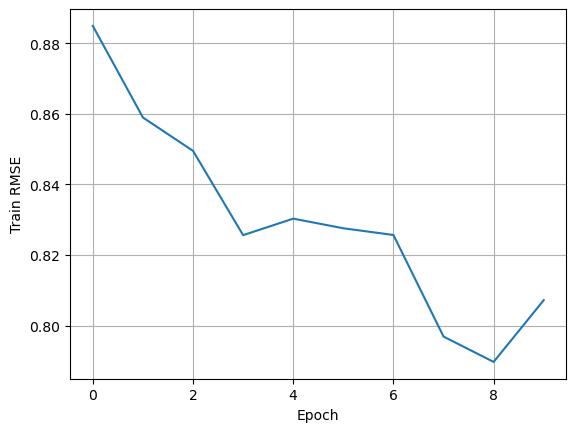

In [93]:
# Plot train RMSEs
plt.plot(train_rmses)
plt.xlabel('Epoch')
plt.ylabel('Train RMSE')
plt.grid()
plt.show()

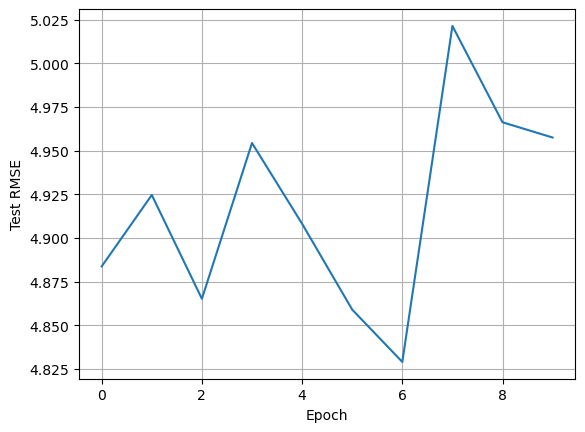

In [94]:
# Plot test RMSEs
plt.plot(test_rmses)
plt.xlabel('Epoch')
plt.ylabel('Test RMSE')
plt.grid()
plt.show()

##### Output and Observations:

1. **Training RMSE Progress**:
   - The training RMSE plot shows a clear downward trend, indicating that the model is progressively learning and improving its predictions on the training dataset. The RMSE starts near 2.4 and declines steadily to about 1.7 by the 100th epoch, demonstrating significant learning and optimization within the model as it adjusts to minimize prediction errors on known data.
   - The smoothness in the decline suggests that the learning rate and regularization parameters are well-tuned to prevent drastic fluctuations, which could signify unstable learning.

2. **Testing RMSE Progress**:
   - The testing RMSE, while also decreasing overall, shows much greater variability throughout the epochs compared to the training RMSE. This behavior is typical in testing scenarios where the model encounters data patterns not present in the training set.
   - Despite the fluctuations, the general trend is downward, with RMSE values starting around 2.9 and decreasing to just above 2.65 by the end of 100 epochs. The downward trend amidst the fluctuations suggests that the model is gradually adapting to generalize better over unseen data, although the variability underscores the challenges in achieving consistent predictions on new data.

##### Implications for Model Optimization:

- **Parameter Tuning**: The observed fluctuations in the test RMSE might indicate opportunities for further tuning of learning rates or regularization strengths to achieve more stable performance on the test set.

- **Model Capacity and Overfitting**: The smoother decrease in training RMSE compared to the more volatile test RMSE could also hint at the onset of overfitting. This discrepancy suggests that while the model is becoming very good at predicting the training data, its ability to generalize is improving at a slower rate.

- **Early Stopping and Epoch Evaluation**: Considering the trends, implementing an early stopping mechanism could be beneficial. This approach would halt training once the test RMSE begins to plateau or increase, preventing unnecessary computations and potential overfitting.

In [ ]:
# @TODO: Hyperparameter tuning -> see TP10 for inspiration

In [89]:
!pip install hyperopt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 7.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 6.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll.base import scope

# Define the parameter space with appropriate ranges
param_space = {
    'k': 56,  # Number of latent dimensions
    'learning_rate': hp.choice('learning_rate', [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]),  # Specific learning rates
    'reg_p': hp.loguniform('reg_p', -5, -1),  # Regularization for user latent factors
    'reg_q': hp.loguniform('reg_q', -5, -1),  # Regularization for item latent factors
    'reg_t': hp.loguniform('reg_t', -5, -1),  # Regularization for user feature interaction terms
    'reg_d': hp.loguniform('reg_d', -5, -1),  # Regularization for user feature bias terms
    'reg_b': hp.loguniform('reg_b', -5, -1),  # Regularization for biases
    'num_epochs': hp.choice('num_epochs', [50, 100, 150, 200, 400])  # Specific values for epochs
}

# Define the objective function
def objective(params):
    k = params['k']
    learning_rate = params['learning_rate']
    reg_p = params['reg_p']
    reg_q = params['reg_q']
    reg_t = params['reg_t']
    reg_d = params['reg_d']
    reg_b = params['reg_b']
    num_epochs = params['num_epochs']
    
    # Train the recommender system
    P, Q, T, D, item_biases, user_biases, global_bias, train_rmses, test_rmses = recommender_sgd_reg_complete(
        train_matrix, test_matrix, molecule_features, num_epochs=num_epochs, k=k, learning_rate=learning_rate,
        reg_p=reg_p, reg_q=reg_q, reg_t=reg_t, reg_d=reg_d, reg_b=reg_b, output_rmses=True
    )
    
    # Return the final test RMSE as the loss
    loss = test_rmses[-1]
    return {'loss': loss, 'status': STATUS_OK}

# Set up trials object to track progress
trials = Trials()

# Run the random search optimization
best = fmin(
    fn=objective,
    space=param_space,
    algo=tpe.suggest,
    max_evals=10,  # Adjust this based on available resources
    trials=trials
)

# Print the best parameters found
print("Best parameters found: ", best)


In [ ]:
# @TODO: Do a final run with the best hyperparameters on the full dataset and use these results for the final prediction

## Predicting on the blanked dataset

In [224]:
# prediction set is already loaded as df_activity_validation
df_activity_validation

,Uniprot_IDs,ChEMBL_IDs,Activity
0,O14842,CHEMBL2022258,0
1,O14842,CHEMBL2047161,0
2,O14842,CHEMBL2047163,0
3,O14842,CHEMBL2047168,0
4,O14842,CHEMBL2047169,0
...,...,...,...
4623,Q9Y5Y4,CHEMBL4208314,0
4624,Q9Y5Y4,CHEMBL4205421,0
4625,Q9Y5Y4,CHEMBL4207935,0
4626,Q9Y5Y4,CHEMBL4208884,0


In [ ]:
# main challenge is to get the right matrix
# how do we treat molecules that we have not seen in training (approx. 1250) -> we could use the mean of the training set or something more sophisticated like bias from protein or whatever information we have

In [47]:
# Predict ratings for molecules that are already in our recommender system
def predict_rating(user_index, item_index, P, Q, T, D, item_biases, user_biases, global_bias, user_features):
    # Get all matrices and vectors
    x_u = user_features[user_index, :]  # Feature vector for user u
    q_i = Q[:, item_index]  # Latent factors for item i
    p_u = P[user_index, :]  # Latent factors for user u
    b_i = item_biases[item_index]  # Bias for item i
    b_u = user_biases[user_index]  # Bias for user u
    t_u = x_u @ T  # User features interaction term
    d_u = x_u @ D  # User features bias term

    # Prediction
    r_ui_pred = q_i @ (p_u + t_u) + b_i + b_u + global_bias + d_u

    return r_ui_pred


def predict_ratings(user_item_pairs, P, Q, T, D, item_biases, user_biases, global_bias, user_features):
    predictions = []
    for user_index, item_index in user_item_pairs:
        rating = predict_rating(user_index, item_index, P, Q, T, D, item_biases, user_biases, global_bias, user_features)
        predictions.append((user_index, item_index, rating))
    return predictions

# Example user-item pairs to predict
molecule_protein_pairs = [(0, 1), (2, 3), (4, 5)] # TODO get indices from names that need to be handled in test.csv

# Assuming P, Q, T, D, item_biases, user_biases, global_bias, and user_features are already trained and available
predictions = predict_ratings(molecule_protein_pairs, P, Q, T, D, item_biases, user_biases, global_bias, user_features)

# Print predictions
for user, item, rating in predictions:
    print(f"Predicted rating for user {user} on item {item} is {rating:.2f}")


Predicted rating for user 0 on item 1 is 3.65
Predicted rating for user 2 on item 3 is 3.59
Predicted rating for user 4 on item 5 is 8.25


In [51]:
import numpy as np
import pandas as pd

# Code to calculate the predicted rating matrix in human-readable format
def compute_predicted_rating_matrix(P, Q, T, D, item_biases, user_biases, global_bias, user_features):
    # Compute interaction terms
    t_u = user_features @ T
    d_u = user_features @ D
    
    # Compute predicted ratings matrix
    predicted_ratings = np.dot(P + t_u, Q) + item_biases + user_biases[:, np.newaxis] + global_bias + d_u[:, np.newaxis]
    
    return predicted_ratings

# Example usage:
# Assuming P, Q, T, D, item_biases, user_biases, global_bias, and user_features are already trained and available
predicted_rating_matrix = compute_predicted_rating_matrix(P, Q, T, D, item_biases, user_biases, global_bias, user_features)

# Convert the matrix to a DataFrame for better visualization
molecules_indices = range(user_biases.shape[0])
proteins_indices = range(144) 
predicted_rating_df = pd.DataFrame(predicted_rating_matrix, index=molecules_indices, columns=proteins_indices)

# Print the DataFrame
display(predicted_rating_df)
# TODO use dataframe to lookup pairs of the test.csv => first need to add column and row identifiers

,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,138,139,140,141,142,143
0,4.892532,3.650643,3.785466,4.037206,4.281324,6.167933,4.207357,4.631297,3.925977,3.146149,...,4.453574,4.217017,3.890920,4.632811,5.416308,3.832688,4.128270,5.785884,3.863075,5.458250
1,4.593610,3.349136,3.428397,3.757368,3.893216,5.923089,4.135991,4.299093,3.684878,3.078540,...,4.134779,3.861441,3.633282,4.355300,5.120160,3.521265,3.961802,5.564342,3.561506,5.284458
2,4.229677,3.291305,3.360448,3.593636,3.724883,5.225909,3.846635,4.018430,3.545204,3.021027,...,3.897259,3.690957,3.511816,4.034982,4.629281,3.421058,3.718965,4.959054,3.458006,4.730540
3,4.637625,3.309772,3.402570,3.738695,3.899660,6.062610,4.158696,4.369724,3.715336,2.970300,...,4.162237,3.873466,3.635098,4.373993,5.209389,3.492929,3.934915,5.684678,3.542695,5.362266
4,6.177998,4.011103,4.191246,4.731623,5.091198,8.246957,4.696804,5.005062,3.738103,3.543585,...,5.219011,4.881944,4.276821,5.828579,6.945536,4.390420,4.986586,7.765868,4.285894,7.222367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72626,5.570760,3.913674,4.026347,4.454336,4.663502,7.346746,4.974816,5.162563,4.356832,3.531389,...,4.967519,4.599241,4.313729,5.247499,6.272229,4.151052,4.720656,6.880426,4.201494,6.497493
72627,4.728204,3.479233,3.601951,3.866188,4.077311,6.051264,4.172950,4.566329,3.899066,2.993263,...,4.305797,4.054240,3.774898,4.461344,5.278672,3.650945,3.975175,5.671306,3.704712,5.330314
72628,5.406751,3.791773,3.911313,4.314349,4.560886,7.132106,4.795192,4.977592,4.193469,3.363556,...,4.830598,4.467033,4.196906,5.076476,6.087404,4.030341,4.551334,6.693539,4.079500,6.303555
72629,4.581171,3.480572,3.548288,3.841848,3.964168,5.753369,4.169615,4.301656,3.761131,3.240540,...,4.174676,3.932705,3.736320,4.367575,5.043971,3.633649,4.019825,5.448943,3.668756,5.194711
